In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import lax
import argparse
import sys
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats as ss
from utils import *

In [2]:
jax.devices()

[CudaDevice(id=0)]

# Load data to get given lddt list in right order

In [3]:
data_path = "/cluster/tufts/pettilab/shared/structure_comparison_data"

In [4]:
val_aln_path = f"{data_path}/protein_data/given_validation_alignments.npz"
coord_path = f"{data_path}/protein_data/allCACoord.npz"
given_lddt_path = f"{data_path}/protein_data/pairs_validation_lddts.csv"


nh_path = f"{data_path}/blurry_vec/nHot.npz"
tmat_path = f"{data_path}/blurry_vec/transition_mtx.npy"
jbl_path = f"{data_path}/blurry_vec/jaccard_blosum_int.npy"

## check that databases have same keys and same length sequences

In [5]:
#hot_d; protien_name: L by alphabet size or num bins + 1; encode sequence in alphabet or nhots
#coord_d; protein_name: L by 3; encodes 3D coordinates

In [6]:
coord_d = np.load(coord_path)
oh_d = np.load(nh_path)
bad_list = check_keys_and_lengths(oh_d, coord_d)

in hot_d but not coord_d:
set()
in coord_d but not hot_d:
{'d1o7d.3', 'd1o7d.2'}


In [7]:
n2l_d = make_name_to_length_d(coord_d)

In [8]:
bad_list.append('d1e25a_')
print(bad_list)

['d1o7d.3', 'd1o7d.2', 'd1e25a_']


In [9]:
# load in validation pairs, their alignments and lddt of them (precomputed in organize_val_and_train)
val_aln_d = dict(np.load(val_aln_path))
val_aln_d_new = {}
for key, val in val_aln_d.items():
    val_aln_d_new[tuple(key.split(','))] = val

val_aln_d = val_aln_d_new
val_aln_d_new = {}
given_lddt_d = {}

# Open the CSV file for reading
with open(given_lddt_path, mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        a, b, value = row[0], row[1], float(row[2])  # Convert value to float
        given_lddt_d[(a, b)] = value
        
print(len(given_lddt_d.keys()))
check_keys(given_lddt_d, val_aln_d)

1518
all keys match


[]

In [10]:
for key in val_aln_d.keys():
    if key[0] in bad_list or key[1] in bad_list:
        raise ValueError(f"pair {key} is bad and should not be used")

## Sort for better batching

In [11]:
# sort pairs by length of longer protein
pair_list = sorted(list(val_aln_d.keys())) 
pair_max_length_pairs = [(pair, max(n2l_d[pair[0]], n2l_d[pair[1]])) for pair in pair_list]
sorted_keys = sorted(pair_max_length_pairs, key=lambda x: (x[1],x[0][0],x[0][1]))
sorted_pairs = [key for key, shape in sorted_keys]
pairs = sorted_pairs
given_lddt_list = [given_lddt_d[pair] for pair in pairs]

## Plot results

In [12]:
def plot(lddt_d, mode = "mean"):# Example dictionary (replace this with your actual data)
    data_dict = lddt_d

    # Get all unique x (o) and y (e) values
    x_values = sorted(set(o for o, e in data_dict.keys()))
    y_values = sorted(set(e for o, e in data_dict.keys()))

    # Create an empty 2D array to store the median values
    grid = np.zeros((len(y_values), len(x_values)))

    # Fill the grid with the median of the lists
   
    for (o, e), values in data_dict.items():
        if mode == "mean":
            val = np.mean(values)
        elif mode == "median":
            val = np.median(values)
        elif mode == "spearman_lddt":
            val =  ss.spearmanr(values, given_lddt_list).correlation
        elif mode == "spearman_tm":
            val =  ss.spearmanr(values, tm_list).correlation
        elif mode == "geo_mean":
            val=(ss.spearmanr(values, given_lddt_list).correlation*np.mean(values))**(1/2.0)
        x_idx = x_values.index(o)
        y_idx = y_values.index(e)
        grid[y_idx, x_idx] = val
    # Create the heatmap
    plt.figure(figsize=(5, 3))
    sns.heatmap(grid, xticklabels=x_values, yticklabels=y_values, cmap='Blues', annot=True,annot_kws={"size": 8})

    # Add labels and title
    plt.xlabel('o values (x-axis)')
    plt.ylabel('e values (y-axis)')
    plt.title(f'{mode} heatmap')

    # Show the plot
    plt.show()

In [13]:
def get_max_key_by_spearman(your_dict):
    return max(your_dict, key=lambda key: ss.spearmanr(your_dict[key], given_lddt_list).correlation)
def get_max_key_by_mean(your_dict):
    return max(your_dict, key=lambda key: np.mean(your_dict[key]))
def get_max_key_by_median(your_dict):
    return max(your_dict, key=lambda key: np.median(your_dict[key]))

In [14]:
data_path = "/cluster/tufts/pettilab/shared/structure_comparison_data"

lddt_d_d ={}
lddt_d_d["BV"] =pickle.load(open(f"{data_path}/blurry_vec/BV_lddt_grid.pkl", "rb"))
for alphabet in ["3Di", "aa",  "dihedral",  "graph_clusters",  "jaccard_vqvae",  "MI"]:
#for alphabet in ["3Di",  "graph_clusters",  "MI"]:
    lddt_d_d[alphabet] = pickle.load(open(f"{data_path}/alphabets/{alphabet}_lddt_grid.pkl", "rb"))

BV


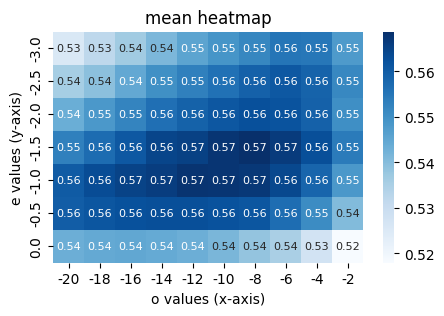

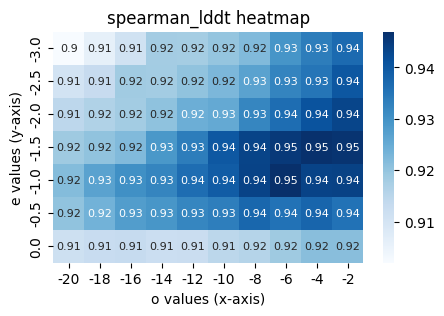

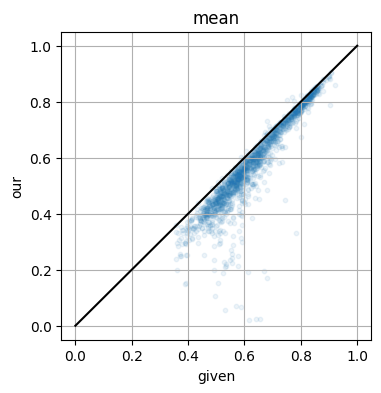

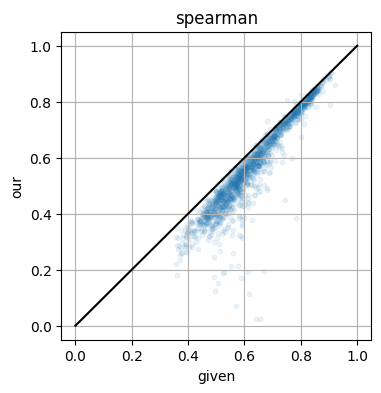

mean -8, -1.5
spearman -6, -1.0


3Di


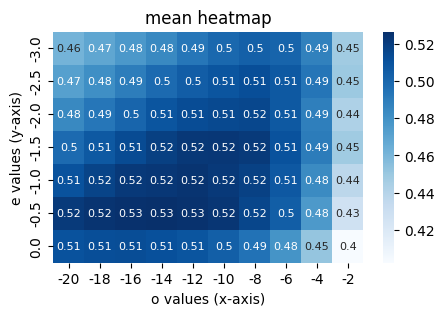

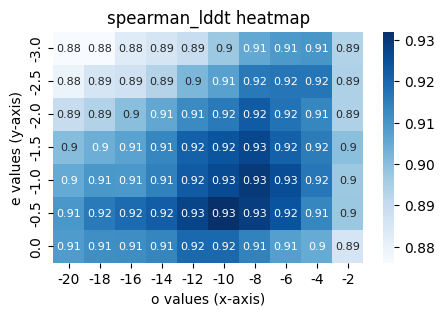

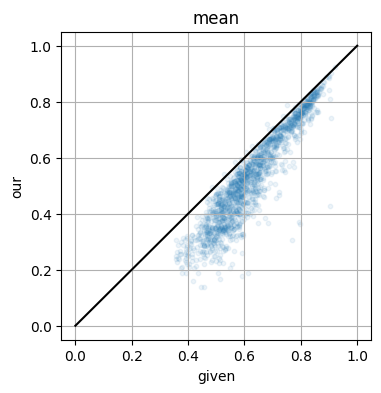

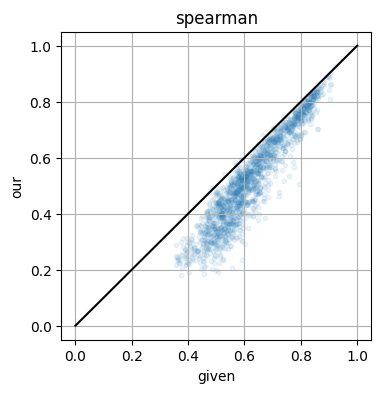

mean -14, -0.5
spearman -10, -0.5


aa


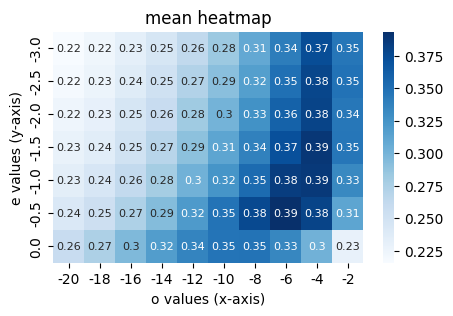

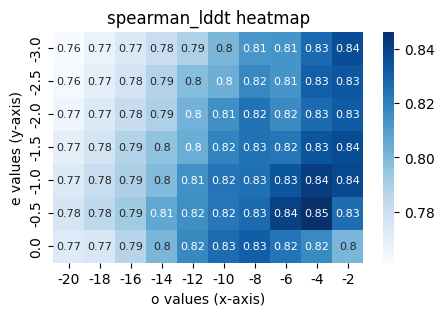

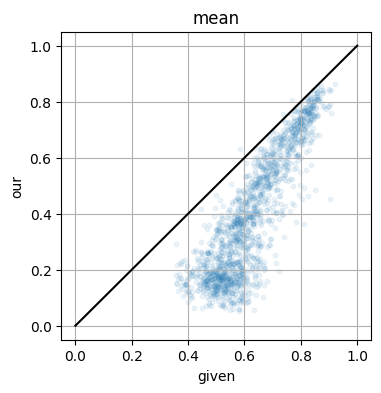

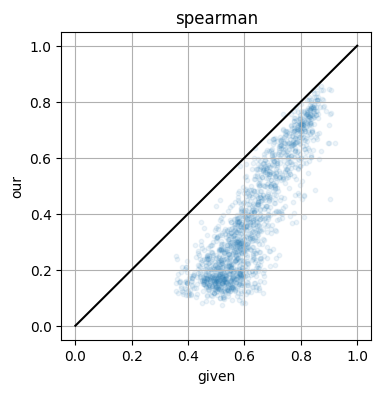

mean -6, -0.5
spearman -4, -0.5


dihedral


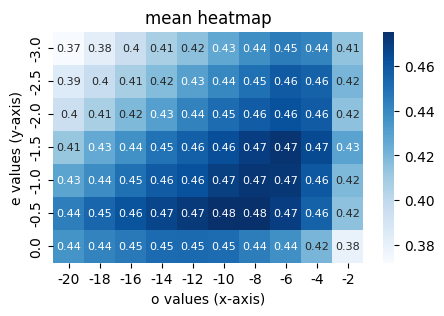

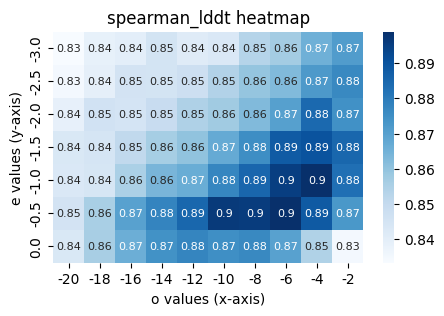

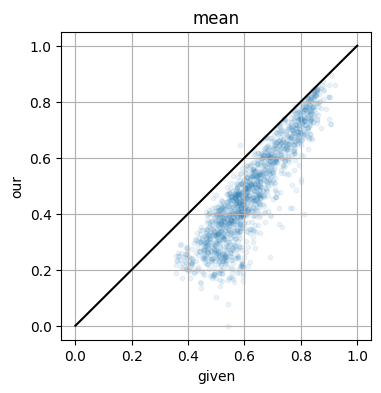

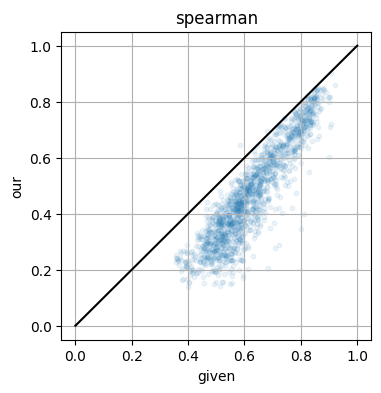

mean -10, -0.5
spearman -6, -0.5


graph_clusters


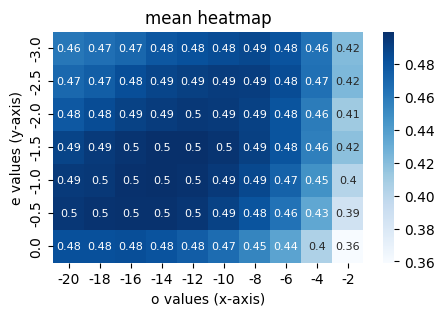

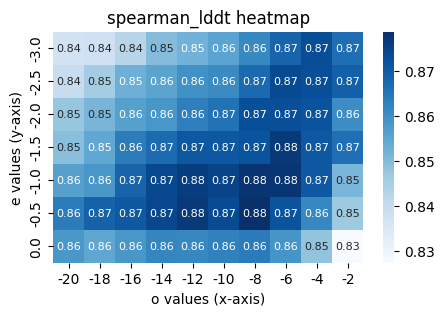

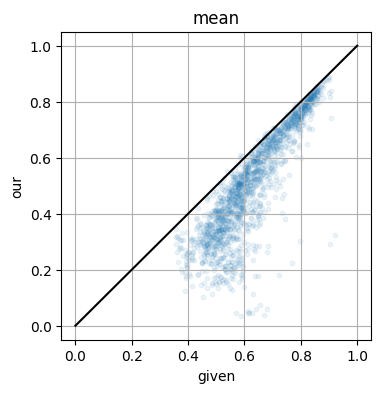

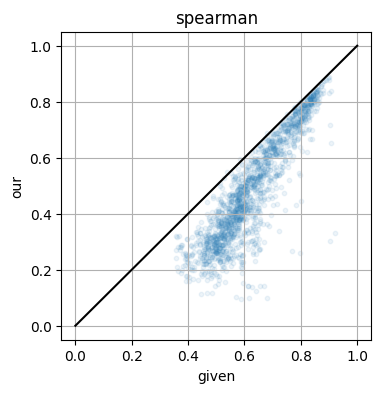

mean -14, -1.5
spearman -8, -0.5


jaccard_vqvae


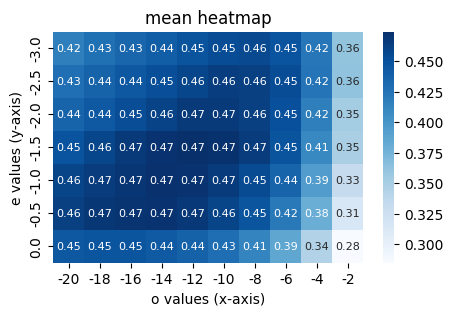

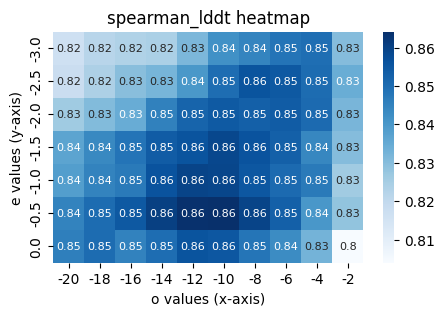

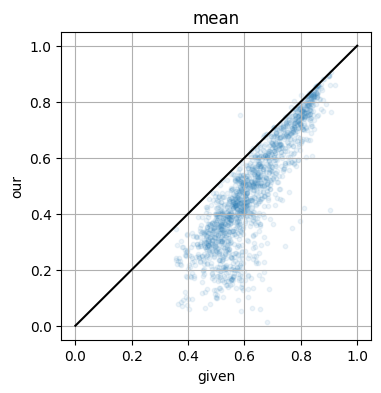

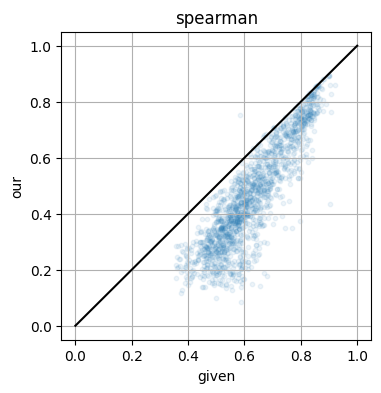

mean -12, -1.5
spearman -10, -0.5


MI


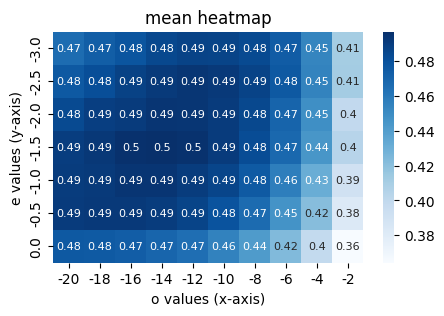

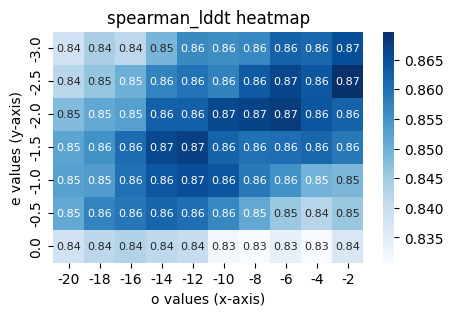

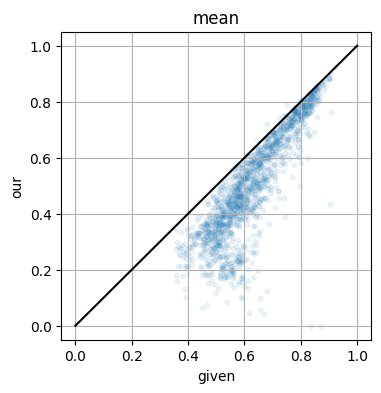

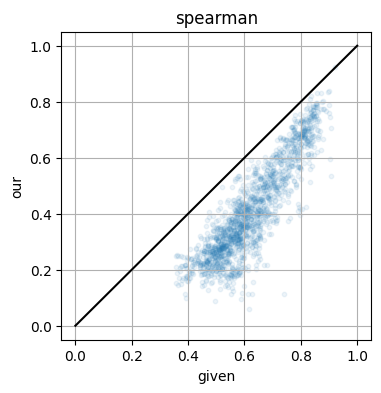

mean -14, -1.5
spearman -2, -2.5




In [15]:
for alphabet in lddt_d_d.keys():
    print(alphabet)
    lddt_d=lddt_d_d[alphabet]
    options = list(lddt_d.keys())
    plot(lddt_d, mode = "mean")
    plot(lddt_d, mode = "spearman_lddt")
    m_key=get_max_key_by_mean(lddt_d)
    s_key = get_max_key_by_spearman(lddt_d)
    for name, key in [("mean", m_key),("spearman",s_key)]:
        plt.figure(figsize=(4, 4))
        plt.scatter(given_lddt_list, lddt_d[key],alpha = .08, s =10)
        plt.xlabel("given")
        plt.ylabel("our")
        plt.title(name)
        plt.plot([0,1],[0,1], color = 'black')
        plt.grid()
        plt.show()
    for name, key in [("mean", m_key),("spearman",s_key)]:
        print(name, f"{key[0]}, {key[1]}")
    print('\n')

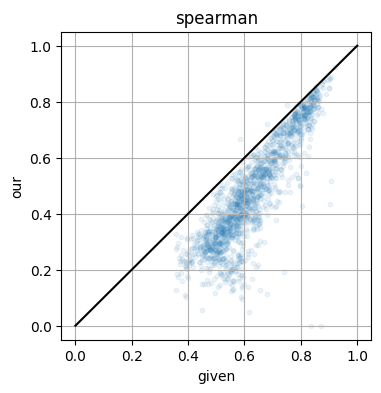

In [16]:
# adjust spearman to the second best for MI
plt.figure(figsize=(4, 4))
plt.scatter(given_lddt_list, lddt_d[(-6,-2)],alpha = .08, s =10)
plt.xlabel("given")
plt.ylabel("our")
plt.title(name)
plt.plot([0,1],[0,1], color = 'black')
plt.grid()
plt.show()

In [17]:
def get_pairs_to_search(p1, p2, options):
    a,b = p1
    c,d = p2
    # Get the min and max for ranges
    x_min, x_max = min(a, c), max(a, c)
    y_min, y_max = min(b, d), max(b, d)

    # Filter pairs that satisfy the constraints
    return [(x, y) for x,y in options if x_min <= x <= x_max and y_min <= y <= y_max]

In [18]:
for alphabet in lddt_d_d.keys():
    lddt_d=lddt_d_d[alphabet]
    options = list(lddt_d.keys())
    m_key=get_max_key_by_mean(lddt_d)
    s_key = get_max_key_by_spearman(lddt_d)
    s = ss.spearmanr(lddt_d[s_key], given_lddt_list).correlation
    m = np.mean(lddt_d[m_key])
    ns = len(get_pairs_to_search(m_key,s_key, options))
    print(f"{alphabet:<15} {s:.4f} {m:.4f} {ns}")    
    

BV              0.9469 0.5687 4
3Di             0.9320 0.5264 3
aa              0.8463 0.3935 2
dihedral        0.8989 0.4754 3
graph_clusters  0.8788 0.4998 12
jaccard_vqvae   0.8641 0.4743 6
MI              0.8697 0.4971 21


## Decide what grid to use

In [19]:
oe_params ={}
for alphabet in lddt_d_d.keys():
    lddt_d=lddt_d_d[alphabet]
    options = list(lddt_d.keys())
    m_key=get_max_key_by_mean(lddt_d)
    s_key = get_max_key_by_spearman(lddt_d)
    s = ss.spearmanr(lddt_d[s_key], given_lddt_list).correlation
    m = np.mean(lddt_d[m_key])
    oe_params[alphabet] = [(float(k[0]),float(k[1])) for k in get_pairs_to_search(m_key,s_key, options)]
    print(alphabet, oe_params[alphabet])

BV [(-8.0, -1.5), (-8.0, -1.0), (-6.0, -1.5), (-6.0, -1.0)]
3Di [(-14.0, -0.5), (-12.0, -0.5), (-10.0, -0.5)]
aa [(-6.0, -0.5), (-4.0, -0.5)]
dihedral [(-10.0, -0.5), (-8.0, -0.5), (-6.0, -0.5)]
graph_clusters [(-14.0, -1.5), (-14.0, -1.0), (-14.0, -0.5), (-12.0, -1.5), (-12.0, -1.0), (-12.0, -0.5), (-10.0, -1.5), (-10.0, -1.0), (-10.0, -0.5), (-8.0, -1.5), (-8.0, -1.0), (-8.0, -0.5)]
jaccard_vqvae [(-12.0, -1.5), (-12.0, -1.0), (-12.0, -0.5), (-10.0, -1.5), (-10.0, -1.0), (-10.0, -0.5)]
MI [(-14.0, -2.5), (-14.0, -2.0), (-14.0, -1.5), (-12.0, -2.5), (-12.0, -2.0), (-12.0, -1.5), (-10.0, -2.5), (-10.0, -2.0), (-10.0, -1.5), (-8.0, -2.5), (-8.0, -2.0), (-8.0, -1.5), (-6.0, -2.5), (-6.0, -2.0), (-6.0, -1.5), (-4.0, -2.5), (-4.0, -2.0), (-4.0, -1.5), (-2.0, -2.5), (-2.0, -2.0), (-2.0, -1.5)]


In [20]:
# add default -10, -1 for 3Di (note very similar as what is optimal as suggested by alignment validation)
oe_params["3Di"].append((-10.0,-1.0))

In [21]:
# MI is too big; subsitute highest spearman for second highest (-6, -2)
alphabet = "MI"
lddt_d=lddt_d_d[alphabet]
options = list(lddt_d.keys())
m_key=get_max_key_by_mean(lddt_d)
s_key = (-6,-2)
s = ss.spearmanr(lddt_d[s_key], given_lddt_list).correlation
m = np.mean(lddt_d[m_key])
ns = len(get_pairs_to_search(m_key,s_key, options))
print(f"{alphabet:<15} {s:.4f} {m:.4f} {ns}")    
oe_params[alphabet] = [(float(k[0]),float(k[1])) for k in get_pairs_to_search(m_key,s_key, options)]

MI              0.8677 0.4971 10


In [22]:
for alphabet in lddt_d_d.keys():
    print(f"{alphabet:<15} {len(oe_params[alphabet])}")    


BV              4
3Di             4
aa              2
dihedral        3
graph_clusters  12
jaccard_vqvae   6
MI              10


## Write config file for each gap/open and extend that we plan to test

In [25]:
ref_path =f"protein_data/ref_names_no_test.csv"
query_list_dir_path = f"protein_data/validation_queries_by_10"
coord_path = "protein_data/allCACoord.npz"
for alphabet in oe_params.keys():
    if alphabet == "BV": continue
    p = pickle.load(open(f"{data_path}/alphabets/{alphabet}_karlin_params.pkl", "rb"))
    for val in oe_params[alphabet]:
        go, ge = val
        path_to_config = f"val_search/{alphabet}/{alphabet}_{go}_{ge}_config"
        with open(path_to_config, 'w') as file:
            file.write(f"data_path: {data_path}" + '\n')
            file.write(f"coord_d: {coord_path}" + '\n')
            file.write(f"oh_d1: alphabets/{alphabet}.npz" +'\n')
            file.write(f"blosum1: alphabets/{alphabet}_blosum.npy" +'\n')
            file.write(f"gap_open: {go}" + '\n')
            file.write(f"gap_extend: {ge}" + '\n')
            file.write(f"lam: {p["lam"]}" + '\n')
            file.write(f"k: {p["k"]}" + '\n')
            file.write(f"refs: {ref_path}"+ '\n')
            file.write(f"query_list_dir: {query_list_dir_path}"+ '\n') 